## Trabalho 2 - ECDB

### Grupo 6
Joana Araújo pg49836

Mariana Silva pg45966

Tiago Silva pg49849

## CYP P450 2C19 Inhibition

### Dataset Description: 

The CYP P450 genes are involved in the formation and breakdown (metabolism) of various molecules and chemicals within cells. Specifically, the CYP P450 2C9 plays a major role in the oxidation of both xenobiotic and endogenous compounds.

### Task Description: 

Binary Classification. Given a drug SMILES string, predict CYP2C9 inhibition.

### Dataset Statistics: 

12,513 drugs.

### References:

[1] Veith, Henrike et al. “Comprehensive characterization of cytochrome P450 isozyme selectivity across chemical libraries.” Nature biotechnology vol. 27,11 (2009): 1050-5.

## Importação de Librarys

In [1]:
import pandas as pd
import scipy.cluster.hierarchy
from scipy import stats
import statsmodels as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, chisquare
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Leitura de dados

In [2]:
df_features = pd.read_csv("cyp2c19_features.csv", sep = ",")
df_cyp2c19 = pd.read_csv("cyp2c19.csv", sep = ",")

#### Verificação da estrutura dos dados e metadados

In [3]:
print("Número de amostras =", df_features.shape[0])
print("Numero de atributos =", df_features.shape[1])
print("Dimensões: ", df_features.shape)
print()
print("Tipo de dados:")
print(df_features.dtypes)
print()
print("Valores Nulos:")
print(df_features.isnull().sum().sum())

Número de amostras = 12513
Numero de atributos = 208
Dimensões:  (12513, 208)

Tipo de dados:
MaxEStateIndex       float64
MinEStateIndex       float64
MaxAbsEStateIndex    float64
MinAbsEStateIndex    float64
qed                  float64
                      ...   
fr_thiazole          float64
fr_thiocyan          float64
fr_thiophene         float64
fr_unbrch_alkane     float64
fr_urea              float64
Length: 208, dtype: object

Valores Nulos:
0


In [4]:
print("Número de amostras =", df_cyp2c19.shape[0])
print("Numero de atributos =", df_cyp2c19.shape[1])
print("Dimensões: ", df_cyp2c19.shape)
print()
print("Tipo de dados:")
print(df_cyp2c19.dtypes)
print()
print("Valores Nulos:")
print(df_cyp2c19.isnull().sum().sum())

Número de amostras = 12513
Numero de atributos = 3
Dimensões:  (12513, 3)

Tipo de dados:
ids       float64
smiles     object
Y           int64
dtype: object

Valores Nulos:
0


In [5]:
print("Valores nulos:")
print(df_cyp2c19.isnull().sum())
print()
print("Valores duplicados:")
print(df_cyp2c19.duplicated(subset=["ids"], keep = False).sum())
print()
print("Número de valores únicos em cada coluna: ")
print(df_cyp2c19.nunique())


Valores nulos:
ids       0
smiles    0
Y         0
dtype: int64

Valores duplicados:
0

Número de valores únicos em cada coluna: 
ids       12513
smiles    12513
Y             2
dtype: int64


In [6]:
print("Valores nulos:")
print(df_features.isnull().sum().sum())
print()
print("Número de valores únicos em cada coluna: ")
print(df_features.nunique())

Valores nulos:
0

Número de valores únicos em cada coluna: 
MaxEStateIndex       12165
MinEStateIndex       12041
MaxAbsEStateIndex    12165
MinAbsEStateIndex    11906
qed                  11443
                     ...  
fr_thiazole              5
fr_thiocyan              2
fr_thiophene             3
fr_unbrch_alkane        20
fr_urea                  4
Length: 208, dtype: int64


#### Análise descritiva, filtragem e pré-processamento dos dados

O conjunto de dados fornecido contém informações sobre drogas, cada uma identificada por um ID único. A composição química de cada droga é representada por uma sequência de caracteres denominada SMILES. Além disso, cada droga possui vários descritores associados, alguns numéricos (tais como qed, MaxEStateIndex, MinEStateIndex, MaxAbsEStateIndex e MinAbsEStateIndex) que descrevem propriedades específicas, e outros binários (0 ou 1), que indicam a presença ou ausência de determinados atributos, bem como a presença ou ausência de subestruturas moléculares (tais como fr_sulfide, fr_sulfonamd, fr_sulfone, fr_term_acetylene, fr_tetrazole )

Uma das propriedades mais importantes é indicada pela letra "Y" que indica se a molécula não inibe (0) ou inibe (1) o gene cyp2c19.

Algumas tarefas de pré-processamento que podem ser necessárias incluem:

- Remoção de valores duplicados e tratamento de valores ausentes

- Conversão de tipos de dados

- Normalização de dados

- Remoção de colunas irrelevantes

In [7]:
df_cyp2c19.describe()

,ids,Y
count,1.251300e+04,12513.000000
mean,6.134883e+06,0.463838
std,1.787283e+07,0.498710
min,1.080000e+02,0.000000
25%,1.324253e+06,0.000000
50%,3.233964e+06,0.000000
75%,4.004272e+06,1.000000
max,1.460310e+08,1.000000


In [8]:
df_cyp2c19.head()

,ids,smiles,Y
0,6602638.0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,0
1,644675.0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1
2,644851.0,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1
3,644890.0,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1
4,644968.0,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1


In [9]:
df_cyp2c19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12513 entries, 0 to 12512
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ids     12513 non-null  float64
 1   smiles  12513 non-null  object 
 2   Y       12513 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 293.4+ KB


In [10]:
df_cyp2c19.groupby("smiles").size()

smiles
Br.C/C(=N/NC1=NCCN1)c1cn(C2=NCCN2)nc1C         1
Br.CC(C)CC1CC(=O)OC1(C)C(=O)CSc1nc2ccccc2s1    1
Br.CC(NC1=NCCCCC1)c1ccccc1                     1
Br.CC1(C(=O)CSc2nc3ccccc3s2)CCC(=O)O1          1
Br.CCCCCCN1Cc2ccccc2C1                         1
                                              ..
c1nc(NCCN2CCOCC2)c2cc(-c3ccoc3)ccc2n1          1
c1nc(NCCc2cnc[nH]2)c2[nH]cnc2n1                1
c1ncc(-c2ccc3c(c2)OCO3)c(NCCc2cnc[nH]2)n1      1
c1ncc(CC2CCNCC2)[nH]1                          1
c1nnc(NCNc2nncs2)s1                            1
Length: 12513, dtype: int64

In [11]:
df_features.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,12513.000000,12513.000000,12513.000000,12513.000000,12513.000000,12513.000000,12513.000000,12513.000000,12513.000000,12513.0,...,12513.000000,12513.000000,12513.000000,12513.000000,12513.000000,12513.000000,12513.000000,12513.000000,12513.000000,12513.000000
mean,11.301366,-0.878665,11.301366,0.191314,0.613183,355.661700,335.440396,355.260983,130.888995,0.0,...,0.108767,0.078398,0.012387,0.003516,0.011508,0.033725,0.000160,0.065692,0.121793,0.041956
std,2.660753,1.453325,2.660753,0.222518,0.190299,105.240375,99.547443,105.127283,39.397215,0.0,...,0.332943,0.278734,0.113464,0.059197,0.109617,0.194590,0.012642,0.255064,0.774348,0.206003
min,2.248446,-7.603764,2.248446,0.000000,0.021258,33.030000,30.006000,33.021465,14.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.976106,-1.039330,10.976106,0.043847,0.484477,292.364000,275.145000,292.124540,106.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.262559,-0.394431,12.262559,0.118089,0.632687,348.478000,328.264000,348.169860,128.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.911008,-0.063559,12.911008,0.234632,0.772393,409.511000,386.258000,409.146030,150.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,17.398045,3.500000,17.398045,3.811700,0.947210,1664.922000,1579.242000,1663.492300,606.000000,0.0,...,4.000000,2.000000,2.000000,1.000000,2.000000,4.000000,1.000000,2.000000,26.000000,3.000000


In [12]:
df_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.609395,0.000000,11.609395,0.000000,0.884168,346.302,321.102,345.13748,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.610409,-3.973681,12.610409,0.072387,0.720978,355.418,346.346,354.96430,114.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,255.05632,88.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,421.25900,164.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,12.040634,-0.208718,12.040634,0.006714,0.728361,324.344,308.216,324.13348,122.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12513 entries, 0 to 12512
Columns: 208 entries, MaxEStateIndex to fr_urea
dtypes: float64(208)
memory usage: 19.9 MB


##### Tipos de dados

In [14]:
type(df_features)

pandas.core.frame.DataFrame

In [15]:
type(df_cyp2c19)

pandas.core.frame.DataFrame

### Exploração gráfica

Primeiramente, vamos verificar o comportamento dos compostos no gene cyp2c19

0    6709
1    5804
Name: Y, dtype: int64


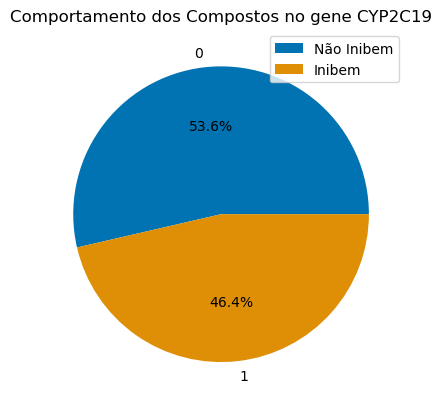

In [16]:
counts = df_cyp2c19['Y'].value_counts()
print(counts)
colours = sns.color_palette("colorblind")[0:2]
plt.pie(counts.values, labels=counts.index, autopct = "%1.1f%%", colors=colours)


plt.title('Comportamento dos Compostos no gene CYP2C19')
plt.legend(["Não Inibem","Inibem"])
plt.show()

In [17]:
print(df_cyp2c19['Y'].value_counts())

0    6709
1    5804
Name: Y, dtype: int64


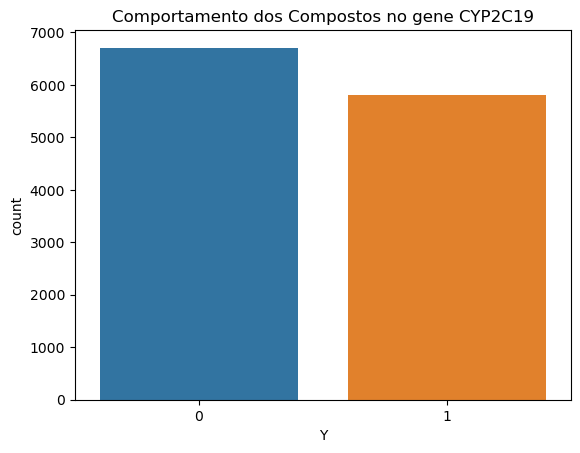

In [18]:
sns.countplot(x='Y', data=df_cyp2c19)
plt.title('Comportamento dos Compostos no gene CYP2C19')
plt.show()

A partir dos gráficos anteriores, pieplot e countplot, conseguimos percebemos que existem mais compostos que não inibem o cyp2c19 (53.6% / 6709) do que os que inibem (46.4% / 5804).


##### Concatenação dos df

De modo a facilitar o trabalho, realizamos a junção dos dataframes

In [19]:
df = pd.concat([df_cyp2c19, df_features], axis = 1)
df

,ids,smiles,Y,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6602638.0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,0,11.609395,0.000000,11.609395,0.000000,0.884168,346.302,321.102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,644675.0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1,12.610409,-3.973681,12.610409,0.072387,0.720978,355.418,346.346,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,644851.0,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,644890.0,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,644968.0,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1,12.040634,-0.208718,12.040634,0.006714,0.728361,324.344,308.216,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12508,16758814.0,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,0,12.346902,-0.801800,12.346902,0.024123,0.682518,263.293,246.157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12509,16758816.0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,0,13.390758,-1.019880,13.390758,0.162294,0.455270,397.427,374.243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12510,16758817.0,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,1,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12511,16758818.0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
print("Dimensões do dataframe concatenado: ", df.shape)
print()
print("Número de valores únicos em cada coluna: ")
print(df.nunique())
print()
print("Valores duplicados:")
print(df.duplicated(subset=["ids"], keep = False).sum())

Dimensões do dataframe concatenado:  (12513, 211)

Número de valores únicos em cada coluna: 
ids                 12513
smiles              12513
Y                       2
MaxEStateIndex      12165
MinEStateIndex      12041
                    ...  
fr_thiazole             5
fr_thiocyan             2
fr_thiophene            3
fr_unbrch_alkane       20
fr_urea                 4
Length: 211, dtype: int64

Valores duplicados:
0


In [21]:
df.apply(lambda x: str(x.min())+"---"+str (x.max()))

ids                                               108.0---146030960.0
smiles              Br.C/C(=N/NC1=NCCN1)c1cn(C2=NCCN2)nc1C---c1nnc...
Y                                                               0---1
MaxEStateIndex                                  2.2484462---17.398045
MinEStateIndex                                       -7.6037636---3.5
                                          ...                        
fr_thiazole                                                 0.0---4.0
fr_thiocyan                                                 0.0---1.0
fr_thiophene                                                0.0---2.0
fr_unbrch_alkane                                           0.0---26.0
fr_urea                                                     0.0---3.0
Length: 211, dtype: object

Verificamos que o dataframe tem 12513 linhas, que indicam as drogas analisados, e 211 colunas, que mostram os parâmetros das drogas. Além de não possui nenhum valor nulo nem duplicado.

#### Filtragem pelo comportamento dos compostos em relação ao gene cyp2c19

In [22]:
df_inhibits = df_features[df_cyp2c19["Y"] == 1]
df_not_inhibits = df_features[df_cyp2c19["Y"] == 0]

In [23]:
df_inhibits

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
1,12.610409,-3.973681,12.610409,0.072387,0.720978,355.418,346.346,354.96430,114.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,255.05632,88.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,421.25900,164.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,12.040634,-0.208718,12.040634,0.006714,0.728361,324.344,308.216,324.13348,122.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,12.850702,-0.112825,12.850702,0.000000,0.506101,514.251,491.067,512.03815,160.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12295,11.645980,-0.177778,11.645980,0.106366,0.775281,317.182,304.078,316.00990,96.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12312,12.773980,-3.673977,12.773980,0.048304,0.735219,387.545,358.313,387.18683,146.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12346,13.490693,-1.088804,13.490693,0.134710,0.509301,458.511,428.271,458.20530,178.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12425,13.165335,-1.060316,13.165335,0.169225,0.326463,390.480,360.240,390.21548,154.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0


In [24]:
df_not_inhibits

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.609395,0.000000,11.609395,0.000000,0.884168,346.302,321.102,345.13748,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,12.762343,-0.533851,12.762343,0.182110,0.757037,380.448,356.256,380.18484,146.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,13.082813,-0.044883,13.082813,0.018472,0.457249,495.628,458.332,495.29578,194.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,11.219078,-0.045417,11.219078,0.045417,0.723254,180.232,172.168,180.03574,62.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14,12.310647,-0.236905,12.310647,0.016681,0.695123,430.574,400.334,430.20386,162.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12507,13.015119,-0.797633,13.015119,0.004523,0.742815,317.385,294.201,317.16272,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12508,12.346902,-0.801800,12.346902,0.024123,0.682518,263.293,246.157,263.11575,102.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12509,13.390758,-1.019880,13.390758,0.162294,0.455270,397.427,374.243,397.15253,152.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12511,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,357.15762,138.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ao separarmos os dataframes pelos compostos que inibem e os que não inibem, verificamos que o número de linhas do dataframe em que Y = 1 é de 5804 linhas e para Y = 0 são 6709 linhas, que indica o número de compostos que inibem e não inibem o gene CYP2C19, respetivamente. Estas informações foram confirmadas anteriormente nos gráficos.

#### Seleção de descritores

No dataframe df_features estão apresentadas algumas propriedades dos compostos que são analisadas nestes estudos, que pretendem mostrar a inibição de um gene quando confrontado com determinado composto.

Selecionamos as colunas que achamos mais pertinentes, passamos a enumerar e descrevê-las.

**BertzCT** :  Esta coluna representa a complexidade estrutural da molécula. É uma medida de descritor molecular que faz parte de um conjunto de descritores que são usados ​​em análises de QSAR (Quantitative Structure-Activity Relationship) para prever a atividade de compostos em relação a uma determinada proteína, neste caso, a cyp2c19. Em geral, quanto maior o valor de BertzCT, mais complexa é a molécula e mais difícil pode ser a sua interação com uma determinada proteína ou enzima.

**MaxEStateIndex**: Esta coluna representa o valor máximo do índice E-estado, que é uma medida da soma das contribuições atómicas para o estado eletrónico de uma molécula. Valores elevados de MaxEStateIndex podem indicar maior densidade eletrónica e potencial para atividade inibitória.

**MinEStateIndex**: Esta coluna representa o valor mínimo do índice E-estado. Valores baixos de MinEStateIndex podem indicar menor densidade eletrónica e potencial para atividade inibitória.

**MaxAbsEStateIndex**: Esta coluna representa o valor máximo absoluto do índice E-estado. Valores elevados de MaxAbsEStateIndex podem indicar maior densidade eletrónica e potencial para atividade inibitória.

**MinAbsEStateIndex**: Esta coluna representa o valor mínimo absoluto do índice E-estado. Valores baixos de MinAbsEStateIndex podem indicar menor densidade eletrónica e potencial para atividade inibitória.

**MaxPartialCharge**: Esta coluna representa a carga parcial máxima de uma molécula, que é uma medida da distribuição de carga dentro de uma molécula. Valores elevados de MaxPartialCharge podem indicar interações eletrostáticas mais fortes e potencial para atividade inibitória.

**MinPartialCharge**: Esta coluna representa a carga parcial mínima de uma molécula, que é uma medida da distribuição de carga dentro de uma molécula. Valores baixos de MinPartialCharge podem indicar interações eletrostáticas mais fracas e potencial para atividade inibitória.

**NumHAcceptors**: Esta coluna representa o número de átomos aceitores de ligações de hidrogénio numa molécula. Valores mais elevados de NumHAcceptors podem indicar a presença de grupos funcionais que podem formar ligações de hidrogénio com proteínas alvo, o que poderia potencialmente contribuir para a atividade inibitória.

**NumHDonors**: Esta coluna representa o número de átomos doadores de ligações de hidrogénio numa molécula. Valores mais elevados de NumHDonors podem indicar a presença de grupos funcionais que podem doar ligações de hidrogénio a proteínas alvo, o que poderia potencialmente contribuir para a atividade inibitória.

**TPSA**: Esta coluna representa a área superficial polar topológica de uma molécula, que é uma medida da superfície de uma molécula que é polar ou capaz de formar ligações de hidrogénio. Valores mais elevados de TPSA podem indicar maior área superficial disponível para interações com proteínas alvo, o que poderia potencialmente contribuir para a atividade inibitória.

**MolWt** : Esta coluna representa um descritor que indica o peso molecular de um composto.

**NumValenceElectrons** : Esta coluna indica o número de eletrões de valência.

**qed** : Esta coluna estima de forma quantitativa a drug-likeness. Varia de 0 a 1, com pontuações mais altas indicando uma maior probabilidade de o composto ser oralmente biodisponível e ter propriedades farmacológicas desejáveis.

**FpDensityMorgan** : Esta coluna representa uma medida de densidade de fragmentos circulares (ou anéis) em torno de um átomo central em uma molécula, calculada usando o algoritmo de Morgan. Em geral, um valor mais alto de FpDensityMorgan3 indica uma maior densidade de trímeros na molécula, o que pode ser associado a uma maior complexidade estrutural e a uma maior dificuldade de interação com a proteína ou enzima alvo.

#### Seleção de MinAbsEStateIndex e MaxAbsEStateIndex

Decidimos selecionar as colunas MaxAbsEStateIndex e MinAbsEStateIndex. O primeiro descritor representa o valor máximo absoluto do índice E-estado, onde valores elevados de MaxAbsEStateIndex podem indicar maior densidade eletrónica e potencial para atividade inibitória. O segundo representa o valor mínimo absoluto do índice E-estado. Valores baixos de MinAbsEStateIndex podem indicar menor densidade eletrónica e potencial para atividade inibitória.

Valores mais altos de MinAbsEStateIndex ou MaxAbsEStateIndex indicam maior polaridade e eletronegatividade da molécula, o que está relacionado a uma maior capacidade mutagénica. Moléculas polares e eletronegativas têm maior probabilidade de interagir com proteínas e DNA, causando danos genéticos e mutações. No entanto, outros fatores, como a estrutura química e a dose, também influenciam a capacidade mutagênica. A polaridade molecular não causa mutação diretamente, mas pode facilitá-la, por exemplo, inibindo enzimas e criando condições favoráveis para mutações.

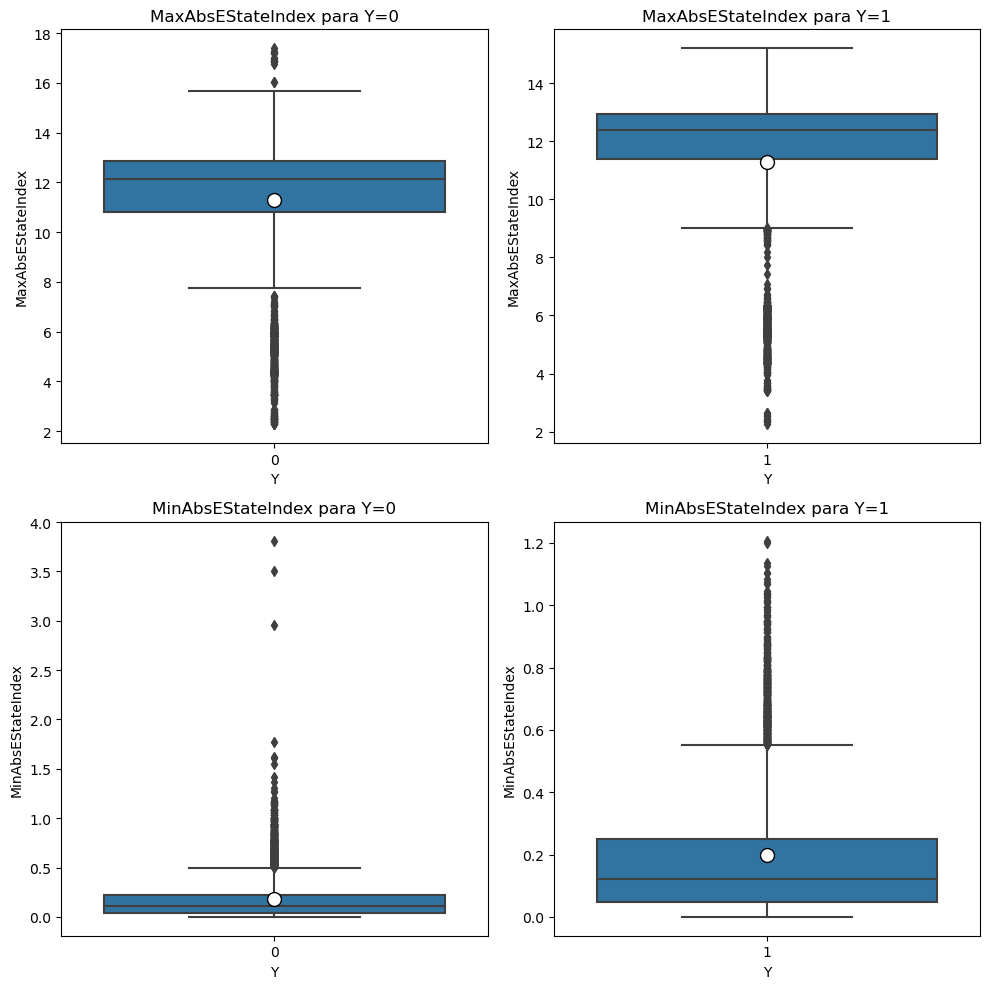

In [25]:
df_y1_maxabs = df[df['Y'] == 1][['Y', 'MaxAbsEStateIndex']]
df_y0_maxabs = df[df['Y'] == 0][['Y', 'MaxAbsEStateIndex']]
df_y1_minabs = df[df['Y'] == 1][['Y', 'MinAbsEStateIndex']]
df_y0_minabs = df[df['Y'] == 0][['Y', 'MinAbsEStateIndex']]

# criar a figura e os subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# plotar cada boxplot nos subplots correspondentes
sns.boxplot(x='Y', y='MaxAbsEStateIndex', data=df_y0_maxabs, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"}, ax=axs[0, 0])
axs[0, 0].set_title('MaxAbsEStateIndex para Y=0')

sns.boxplot(x='Y', y='MaxAbsEStateIndex', data=df_y1_maxabs, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"}, ax=axs[0, 1])
axs[0, 1].set_title('MaxAbsEStateIndex para Y=1')

sns.boxplot(x='Y', y='MinAbsEStateIndex', data=df_y0_minabs, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"}, ax=axs[1, 0])
axs[1, 0].set_title('MinAbsEStateIndex para Y=0')

sns.boxplot(x='Y', y='MinAbsEStateIndex', data=df_y1_minabs, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"}, ax=axs[1, 1])
axs[1, 1].set_title('MinAbsEStateIndex para Y=1')

# ajustar o espaçamento entre os subplots
plt.tight_layout()

# exibir o gráfico
plt.show()

Apesar de ser suposto que quanto maior o valor do MinAbsEState e MaxAbsEState maior a sua polaridade e eletronegatividade da molécula, maior probabilidade terá de ser mutagénica, os boxplots não nos dão informações muito claras sobre tal. Este resultado pode ter a ver com o facto de que apenas estes descritores não são suficientes para associar a capacidade mutagénica. Sem contar que exise uma grande presença de outliers que podem ter uma interferência negativa nos nosso dados.

#### Seleção de TPSA

Passando a análise para a coluna TPSA. Esta coluna representa a área superficial polar topológica de uma molécula, que é uma medida da superfície de uma molécula que é polar ou capaz de formar ligações de hidrogénio. Valores mais elevados de TPSA podem indicar maior área superficial disponível para interações com proteínas alvo, o que poderia potencialmente contribuir para a atividade inibitória.

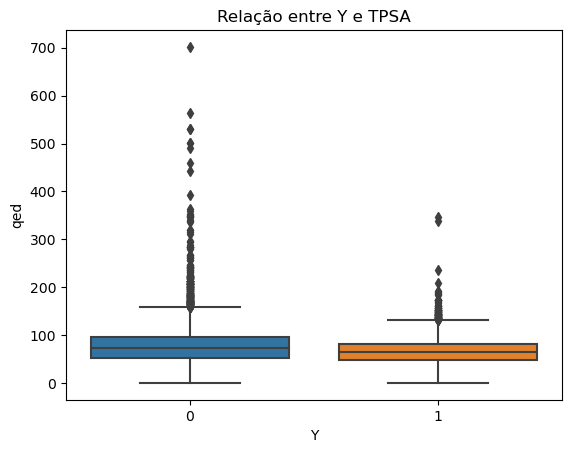

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

df_y1 = df[df['Y'] == 1]
df_y0 = df[df['Y'] == 0]

sns.boxplot(x='Y', y='TPSA', data=df)
plt.title('Relação entre Y e TPSA')
plt.xlabel('Y')
plt.ylabel('qed')
plt.show()

A partir desta análise não é possível retirar conclusões pertinentes, uma vez que os boxplots apresentam uma mediana, assim como os seus quartis, nem valores semelhantes. Isto não significa que esta medida não seja capaz de indicar corretamente a quantidade de ligações de hidrogénio e a sua realção com a atividade inibitório, mas sim temos que considerar que a capacidade mutagénico também depende de outros fatores.

#### Seleção de fragmentos "fr_"

Uma categoria de análise que achamos de interesse é representada pela fração molar de compostos em cada molécula, identificada como "fr_". Conforme descrito na literatura, certas moléculas químicas podem estar relacionadas à capacidade mutagénica de uma molécula. Por exemplo, certos grupos funcionais, como grupos nitro, ou estruturas aromáticas, como anéis benzénicos, podem aumentar a capacidade mutagénica de uma molécula. Portanto, a presença de determinadas subestruturas químicas na coluna "fr_" pode indicar se uma molécula tem um potencial maior ou menor de ser mutagénica[1]

In [27]:
cols_fr = df.filter(regex='^fr_').columns

scaler = StandardScaler()
df[cols_fr] = scaler.fit_transform(df[cols_fr])
df[cols_fr] 

,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.230982,-0.268182,-0.256877,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
1,-0.230982,-0.268182,-0.256877,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,3.306514,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,3.663181,-0.157291,-0.203677
2,-0.230982,-0.268182,-0.256877,-0.187528,-0.13945,1.123587,2.798545,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
3,-0.230982,-0.268182,-0.256877,-0.187528,-0.13945,2.459719,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,9.018047,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
4,-0.230982,-0.268182,-0.256877,-0.187528,-0.13945,2.459719,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,9.018047,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12508,-0.230982,1.194661,1.351077,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
12509,-0.230982,1.194661,1.351077,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
12510,-0.230982,1.194661,1.351077,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
12511,-0.230982,2.657504,2.959031,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677


In [28]:
index = df.columns.get_loc("fr_Al_COO")
index

fr = df.iloc[:, index:]
fr

,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.230982,-0.268182,-0.256877,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
1,-0.230982,-0.268182,-0.256877,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,3.306514,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,3.663181,-0.157291,-0.203677
2,-0.230982,-0.268182,-0.256877,-0.187528,-0.13945,1.123587,2.798545,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
3,-0.230982,-0.268182,-0.256877,-0.187528,-0.13945,2.459719,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,9.018047,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
4,-0.230982,-0.268182,-0.256877,-0.187528,-0.13945,2.459719,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,9.018047,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12508,-0.230982,1.194661,1.351077,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
12509,-0.230982,1.194661,1.351077,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
12510,-0.230982,1.194661,1.351077,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
12511,-0.230982,2.657504,2.959031,-0.187528,-0.13945,-0.880610,-0.297123,-0.199906,-0.269935,-0.27024,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677


In [29]:
fr.describe()

,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,1.251300e+04,1.251300e+04,12513.000000,12513.000000,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,...,1.251300e+04,1.251300e+04,12513.000000,12513.000000,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04
mean,1.817100e-17,3.179924e-17,0.000000,0.000000,3.179924e-17,1.544535e-16,4.315612e-17,-9.085498e-18,1.817100e-17,-4.542749e-17,...,1.817100e-17,6.814124e-17,0.000000,0.000000,6.246280e-18,4.542749e-17,3.407062e-18,4.542749e-17,4.542749e-18,-5.905574e-17
std,1.000040e+00,1.000040e+00,1.000040,1.000040,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,...,1.000040e+00,1.000040e+00,1.000040,1.000040,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00
min,-2.309819e-01,-2.681821e-01,-0.256877,-0.187528,-1.394504e-01,-8.806103e-01,-2.971228e-01,-1.999058e-01,-2.699355e-01,-2.702396e-01,...,-3.266962e-01,-2.812774e-01,-0.109177,-0.059403,-1.049882e-01,-1.733201e-01,-1.264355e-02,-2.575601e-01,-1.572912e-01,-2.036772e-01
25%,-2.309819e-01,-2.681821e-01,-0.256877,-0.187528,-1.394504e-01,-8.806103e-01,-2.971228e-01,-1.999058e-01,-2.699355e-01,-2.702396e-01,...,-3.266962e-01,-2.812774e-01,-0.109177,-0.059403,-1.049882e-01,-1.733201e-01,-1.264355e-02,-2.575601e-01,-1.572912e-01,-2.036772e-01
50%,-2.309819e-01,-2.681821e-01,-0.256877,-0.187528,-1.394504e-01,-2.125445e-01,-2.971228e-01,-1.999058e-01,-2.699355e-01,-2.702396e-01,...,-3.266962e-01,-2.812774e-01,-0.109177,-0.059403,-1.049882e-01,-1.733201e-01,-1.264355e-02,-2.575601e-01,-1.572912e-01,-2.036772e-01
75%,-2.309819e-01,-2.681821e-01,-0.256877,-0.187528,-1.394504e-01,4.555212e-01,-2.971228e-01,-1.999058e-01,-2.699355e-01,-2.702396e-01,...,-3.266962e-01,-2.812774e-01,-0.109177,-0.059403,-1.049882e-01,-1.733201e-01,-1.264355e-02,-2.575601e-01,-1.572912e-01,-2.036772e-01
max,1.502919e+01,1.728593e+01,19.038573,16.754963,2.187875e+01,4.463916e+00,1.208555e+01,2.088689e+01,1.309123e+01,1.308485e+01,...,1.168785e+01,6.894306e+00,17.518290,16.834083,1.814108e+01,2.038359e+01,7.909172e+01,7.583922e+00,3.342067e+01,1.435982e+01


In [30]:
#filtração das colunas em que Y == 1
df_filtered = df.loc[df['Y'] == 1].filter(regex='^fr_')

#média das colunas e obter o nome da coluna com maior e menor média
col_max = df_filtered.mean().idxmax()
col_min = df_filtered.mean().idxmin()

print(f"Coluna com maior média: {col_max}")
print(f"Coluna com menor média: {col_min}")

Coluna com maior média: fr_benzene
Coluna com menor média: fr_COO2


In [31]:
#filtração das colunas em que Y == 0
df_filtered = df.loc[df['Y'] == 0].filter(regex='^fr_')

col_max = df_filtered.mean().idxmax()
col_min = df_filtered.mean().idxmin()

print(f"Coluna com maior média: {col_max}")
print(f"Coluna com menor média: {col_min}")

Coluna com maior média: fr_COO2
Coluna com menor média: fr_benzene


A partir desta informação percebemos que quando Y = 1, ou seja, inibe cyp2c19, o composto com maior média é o fr_benzene e o com menor média é o fr_COO2. Por outro lado, quando Y=0, ou seja, não há inibição de cyp2c19, o composto com maior média é fr_COO2 e com menor média é o fr_benzene. Verifica-se um oposto nos casos, pelo que se pode prever que o composto fr_benzene pode estar relacionado com a inibição de cyp2c19. 

Os resultados estão de acordo com a literatura. O "fr_benzene" pode indicar a capacidade mutagénica dos compostos no conjunto de dados, pois o benzeno é conhecido por ser altamente cancerígeno e mutagénico. No entanto, não há evidências científicas que relacionem diretamente o "COO2" com a capacidade mutagénica, o que é verificado pelos resultados.

#### Seleção de SMR

Outro grupo analisado foi o "SMR_VSA", que mede a distribuição da área superficial da molécula em diferentes regiões. É um descritor molecular usado para prever a atividade biológica de compostos químicos.

In [32]:
cols_SMR = df.filter(regex='^SMR_VSA').columns

scaler = StandardScaler()
df[cols_SMR] = scaler.fit_transform(df[cols_SMR])
df[cols_SMR]

,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9
0,-0.794903,1.469107,-0.246056,-0.702759,-0.565239,0.148597,1.940887,-1.134467,0.0,-0.800333
1,0.386925,2.460392,-0.246056,-1.379096,-0.565239,-0.559127,-0.848612,-0.293891,0.0,-0.800333
2,-1.236379,-0.746285,-0.246056,0.716390,-0.565239,-1.065615,-1.159452,0.242220,0.0,2.071439
3,-0.800214,-1.611947,-0.246056,3.450732,-0.565239,0.703979,1.244029,0.473819,0.0,-0.075382
4,-0.358738,-1.171153,-0.246056,2.831938,-0.565239,-0.470112,-0.646119,0.043097,0.0,1.360505
...,...,...,...,...,...,...,...,...,...,...
12508,0.558253,-0.298814,-0.246056,-0.702759,2.826620,0.111302,-0.686915,-1.553156,0.0,-0.800333
12509,1.425273,-0.730359,-0.246056,-0.702759,1.978655,0.912739,-0.205407,-0.214512,0.0,-0.800333
12510,1.425273,-0.730359,-0.246056,-0.702759,1.978655,0.929981,0.267130,-1.572177,0.0,-0.800333
12511,1.028456,-0.298814,-0.246056,-0.702759,2.826620,0.955985,-1.159452,-0.655116,0.0,-0.800333


In [33]:
index = df.columns.get_loc("SMR_VSA1")
index

svm = df.iloc[:, index:]

In [34]:
svm.describe()

,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,12513.0,1.251300e+04,...,1.251300e+04,1.251300e+04,12513.000000,12513.000000,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04,1.251300e+04
mean,4.542749e-17,2.907359e-16,-7.722673e-17,-1.090260e-16,-8.176948e-17,2.271375e-17,1.090260e-16,2.725649e-16,0.0,1.362825e-17,...,1.817100e-17,6.814124e-17,0.000000,0.000000,6.246280e-18,4.542749e-17,3.407062e-18,4.542749e-17,4.542749e-18,-5.905574e-17
std,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,0.0,1.000040e+00,...,1.000040e+00,1.000040e+00,1.000040,1.000040,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00
min,-1.236379e+00,-1.611947e+00,-2.460560e-01,-1.379096e+00,-5.652389e-01,-1.065615e+00,-1.159452e+00,-2.012782e+00,0.0,-8.003333e-01,...,-3.266962e-01,-2.812774e-01,-0.109177,-0.059403,-1.049882e-01,-1.733201e-01,-1.264355e-02,-2.575601e-01,-1.572912e-01,-2.036772e-01
25%,-7.949030e-01,-7.342750e-01,-2.460560e-01,-7.027594e-01,-5.652389e-01,-7.506218e-01,-7.755754e-01,-6.882250e-01,0.0,-8.003333e-01,...,-3.266962e-01,-2.812774e-01,-0.109177,-0.059403,-1.049882e-01,-1.733201e-01,-1.264355e-02,-2.575601e-01,-1.572912e-01,-2.036772e-01
50%,-3.246993e-01,-2.802941e-01,-2.460560e-01,-1.481903e-02,-5.652389e-01,-2.010384e-01,-2.321430e-01,2.909215e-02,0.0,-8.321491e-02,...,-3.266962e-01,-2.812774e-01,-0.109177,-0.059403,-1.049882e-01,-1.733201e-01,-1.264355e-02,-2.575601e-01,-1.572912e-01,-2.036772e-01
75%,4.894649e-01,5.430126e-01,-2.460560e-01,6.731213e-01,2.563267e-01,4.005890e-01,7.253546e-01,6.641561e-01,0.0,6.355531e-01,...,-3.266962e-01,-2.812774e-01,-0.109177,-0.059403,-1.049882e-01,-1.733201e-01,-1.264355e-02,-2.575601e-01,-1.572912e-01,-2.036772e-01
max,9.842965e+00,1.200062e+01,1.475961e+01,1.013327e+01,1.101802e+01,1.363347e+01,8.796699e+00,7.884272e+00,0.0,9.208229e+00,...,1.168785e+01,6.894306e+00,17.518290,16.834083,1.814108e+01,2.038359e+01,7.909172e+01,7.583922e+00,3.342067e+01,1.435982e+01


In [35]:
df_filtered = df.loc[df['Y'] == 1].filter(regex='^SMR_VSA')

col_max = df_filtered.mean().idxmax()
col_min = df_filtered.mean().idxmin()

print(f"Coluna com maior média: {col_max}")
print(f"Coluna com menor média: {col_min}")

Coluna com maior média: SMR_VSA7
Coluna com menor média: SMR_VSA4


In [36]:
df_filtered = df.loc[df['Y'] == 0].filter(regex='^SMR_VSA')

col_max = df_filtered.mean().idxmax()
col_min = df_filtered.mean().idxmin()

print(f"Coluna com maior média: {col_max}")
print(f"Coluna com menor média: {col_min}")

Coluna com maior média: SMR_VSA4
Coluna com menor média: SMR_VSA7


Moléculas com maior área superficial em uma região específica podem ter maior probabilidade de interagir com o DNA, o que pode resultar em uma maior capacidade mutagénica. No entanto, a capacidade mutagénica de uma molécula também pode ser influenciada por outros fatores, como sua carga elétrica, polaridade e solubilidade em água, que afetam sua interação com o DNA. Portanto, embora uma pontuação mais alta de SMR_VSA em uma ou mais regiões possa indicar uma maior capacidade mutagénica, essa relação é complexa e depende de vários outros fatores.

#### Seleção do QED

Esta medida estima de forma quantitativa a drug-likeness. Varia de 0 a 1, com pontuações mais altas indicando uma maior probabilidade de o composto ser oralmente biodisponível e ter propriedades farmacológicas desejáveis.
Desta forma, pretende-se verificar se os dados obtidos estão de acordo com expectável, onde se o qed tiver um valor muito elevado o fármaco é bom e portanto não terá capacidade mutagénica presente.

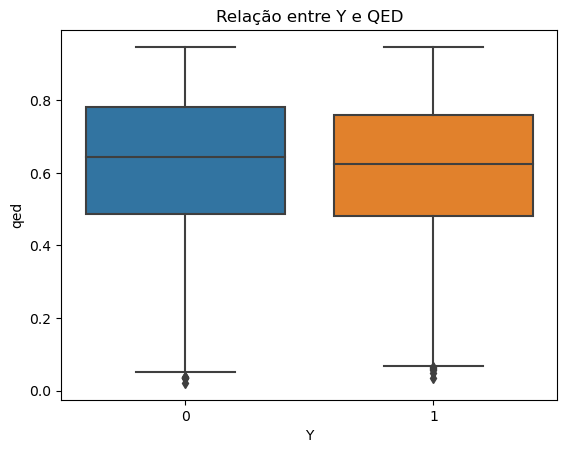

In [37]:
df_y1 = df[df['Y'] == 1]
df_y0 = df[df['Y'] == 0]

sns.boxplot(x='Y', y='qed', data=df)
plt.title('Relação entre Y e QED')
plt.xlabel('Y')
plt.ylabel('qed')
plt.show()

Novamente, a análise de apenas um descritor não consegue correlacionar as informações encontradas em literatura, onde os compostos com maior valor de QED apresentam uma menor capacidade mutagénica. 

## Análise Estatística Univariada

Uma vez que as análise anteriores não mostraram resultados esperdos, vamos realizar testes estatísticos  para perceber a relevância das features em relação a seu comportamente mutagénico.


In [38]:
norm = [] 
not_norm = [] 

for col in df.iloc[:, 3:208]:
    stat, p_value = shapiro(df[col])
    
    if p_value > 0.05:
        norm.append(col)
    else:
        not_norm.append(col)

print(f'Distribuição normal: ', norm)
print(f'Sem distribuição normal: ', not_norm)

c:\Users\Fofinha\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Fofinha\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Distribuição normal:  ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_prisulfonamd']
Sem distribuição normal:  ['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'S

Verifica-se que apenas 4 colunas seguem distribuição normal, por isso, para estas irão ser apelicados testes estatísticos paramétricos (t-test) enquanto que para as restantes irão ser aplicados testes não paramétricos (Mann-Whitney)

H0: Não existem diferenças significativas entre a propriedade do composto químico e a inibição deCYP2C19.

H1: Existem diferenças significativas entre a propriedade do composto químico e a inibição de CYP2C19.

In [39]:
for column in norm:
    y0 = df.loc[df['Y'] == 0, col]
    y1 = df.loc[df['Y'] == 1, col]
    stat, p_value = ttest_ind(y0, y1)
print("P-value das colunas normais:", p_value)

col_notnorm = [col for col in df.columns[3:211] if col not in norm]
res = {}

for col in col_notnorm:
    y0 = df.loc[df['Y'] == 0, col]
    y1 = df.loc[df['Y'] == 1, col]
    stat, p_value = mannwhitneyu(y0, y1, alternative='two-sided')
    res[col] = p_value

P-value das colunas normais: 0.1883772308376751


C:\Users\Fofinha\AppData\Local\Temp\ipykernel_36076\3058770794.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, p_value = ttest_ind(y0, y1)


Das colunas que não tem distribuiçao normal, vamos selecionar as 15 colunas com base no seu valor p.

In [40]:
sorted_res = sorted(res.items(), key=lambda x: x[1])
lowest_values = sorted_res[:15]

for item in lowest_values:
    print(item)

top15 = [col[0] for col in lowest_values[:10]]
top15.insert(0, "Y")
top15


('SMR_VSA7', 0.0)
('MolLogP', 0.0)
('VSA_EState6', 1.5620007439775988e-305)
('SlogP_VSA6', 1.9520400067913854e-300)
('NumAromaticCarbocycles', 2.5177225489833657e-261)
('fr_benzene', 1.1712584256868853e-260)
('NumAromaticRings', 8.347760207038353e-260)
('FractionCSP3', 3.6497674039115837e-237)
('SlogP_VSA2', 1.6644634691558658e-206)
('PEOE_VSA6', 3.5838023196321876e-198)
('VSA_EState10', 1.8933838229500555e-195)
('SlogP_VSA12', 4.675559480923472e-186)
('EState_VSA7', 6.2665700119541556e-167)
('BCUT2D_MRHI', 5.592559730262619e-163)
('BCUT2D_MWHI', 5.0888524174069396e-139)


['Y',
 'SMR_VSA7',
 'MolLogP',
 'VSA_EState6',
 'SlogP_VSA6',
 'NumAromaticCarbocycles',
 'fr_benzene',
 'NumAromaticRings',
 'FractionCSP3',
 'SlogP_VSA2',
 'PEOE_VSA6']

#### Testes de avaliação de expressão diferencial

Para a análise estatística univariada usamos testes estatísticos para identificar compostos com características diferentes em relação à variável "Y" (entre composto que inibem ou não inibem). 

H0: Não existem diferenças significativas entre a propriedade do composto químico e a inibição deCYP2C19.

H1: Existem diferenças significativas entre a propriedade do composto químico e a inibição de CYP2C19.

In [41]:
pvalues = []
for col in df.columns:
    sel_cols = df.iloc[:, 3:126]
    if col in sel_cols:
        contingency_table=pd.crosstab(df[col], df['Y'])
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        pvalues.append(p_value)
        if p_value < 0.05:
            print(f"O descritor químico {col} tem expressão diferencial significativa com p-value: {p_value}")
        else:
            print(f"O descritor químico {col} não tem expressão diferencial significativa com p-value: {p_value}")

sign = len(df[df['Y'] == 0]) + len(df[df['Y'] == 1])
sign

O descritor químico MaxEStateIndex não tem expressão diferencial significativa com p-value: 0.06902245553392261
O descritor químico MinEStateIndex tem expressão diferencial significativa com p-value: 0.0437611271965757
O descritor químico MaxAbsEStateIndex não tem expressão diferencial significativa com p-value: 0.06902245553392261
O descritor químico MinAbsEStateIndex tem expressão diferencial significativa com p-value: 0.0411145933288604
O descritor químico qed tem expressão diferencial significativa com p-value: 2.8281147731386506e-06
O descritor químico MolWt tem expressão diferencial significativa com p-value: 1.4539242176416733e-19
O descritor químico HeavyAtomMolWt tem expressão diferencial significativa com p-value: 9.30289157263313e-43
O descritor químico ExactMolWt tem expressão diferencial significativa com p-value: 1.3816622999308828e-19
O descritor químico NumValenceElectrons tem expressão diferencial significativa com p-value: 8.410387238182544e-88
O descritor químico Num

12513

In [42]:
descritores = df.iloc[:,3:126:]

sign=[]
not_sign=[]
count = 0
for x, t in enumerate(descritores):
    not_inibited = df[df['Y'] == 0][t]
    inibited = df[df['Y'] == 1][t]
    p_value = ttest_ind(not_inibited, inibited)[1]
    if p_value < 0.05:
        count += 1
        sign.append(t)
    else:
        not_sign.append(t)

significativa = len(sign+not_sign) - count - 1

print(f"Grupos funcionais com expressão diferencial signficativa: {len(sign)}")
print(f"Grupos funcionais com expressão diferencial não signficativa: {len(not_sign)}")
print(f"Lista de grupos funcionais com expressão diferencial signficativa: {sign}")
print(f"Lista de grupos funcionais com expressão diferencial não signficativa: {not_sign} ")

Grupos funcionais com expressão diferencial signficativa: 107
Grupos funcionais com expressão diferencial não signficativa: 16
Lista de grupos funcionais com expressão diferencial signficativa: ['MinEStateIndex', 'MinAbsEStateIndex', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Kappa1', 'Kappa2', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'S

H0: A quantidade de grupos funcionais em cada composto tem influência na inibição do gene de estudo CYP2C19.

H1: A quantidade de grupos funcionais em cada composto não tem influencia na inibição do gene de estudo CYP2C19.

In [43]:
compostos = df.iloc[:, 126:]
compostos1 = compostos.insert(loc = 0,
          column = 'Y',
          value = df["Y"])
sign = []
not_sign = []
count=0
for x, y in enumerate(compostos):
    a = pd.crosstab(compostos["Y"],compostos[y])
    b = scipy.stats.chi2_contingency(a)[1]
    if b > 0.05:
        count +=1
        not_sign.append(y)
    else:
        sign.append(y)

significativos = len(sign+not_sign) - count -1
sign.pop(0)
print(f"Grupos funcionais com expressão diferencial signficativa: {significativos}")
print(f"Grupos funcionais com expressão diferencial não signficativa: {count}")
print(f"Lista de grupos funcionais com expressão diferencial signficativa: {sign}")
print(f"Lista de grupos funcionaiscom expressão diferencial não signficativa: {not_sign} ")

Grupos funcionais com expressão diferencial signficativa: 70
Grupos funcionais com expressão diferencial não signficativa: 15
Lista de grupos funcionais com expressão diferencial signficativa: ['fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_aniline', 'fr_aryl_methyl', 'fr_azo', 'fr_benzene', 'fr_bicyclic', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_ketone', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid',

Verifica-se que existem 70 grupos funcionais que têm influência significativa na inibição do gene CYP2C19, e 19 grupos funcionais não têm influência significativa na inibição do gene, para um nível de significância de 0.05.

Observa-se também que os grupos fr_COO2 e fr_benzene estão na lista dos grupos funcionais com expressão diferncial significativa.

#### Matriz de correlação

Para realizar a matriz de correlação, selecionamos as 15 colunas com menor p-value. Uma matriz de correlação é uma ferramenta importante na análise de dados, especialmente quando se lida com múltiplas variáveis. Ela mostra as relações entre pares de variáveis, medindo o grau de associação linear entre elas.
A correlação é uma medida que descreve a relação entre duas variáveis. Ela pode ser positiva, negativa ou nula. Quando duas variáveis têm uma correlação positiva forte, significa que elas tendem a aumentar ou diminuir juntas, e o valor de correlação aproxima-se de 1. Por outro lado, uma correlação negativa forte indica que quando uma variável aumenta, a outra tende a diminuir, e o valor de correlação aproxima-se de -1. Por fim, uma correlação próxima de zero significa que não há uma relação clara entre as variáveis.



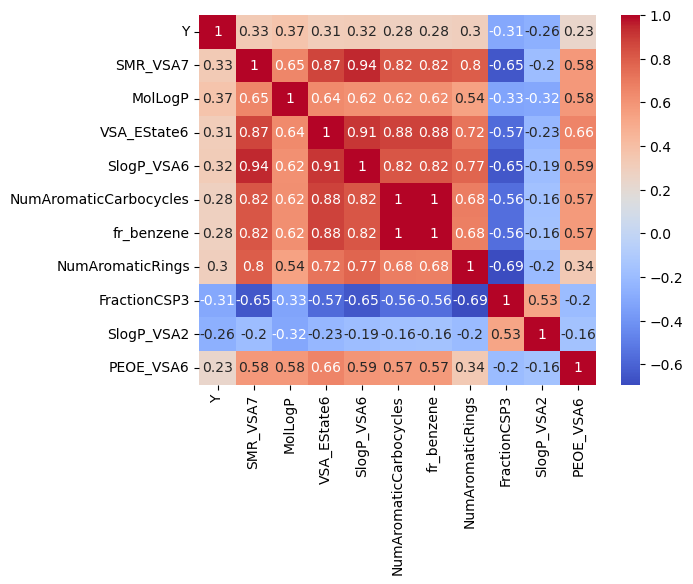

In [44]:
df_top_15 = df[top15]

corr = df_top_15.corr()

sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

# ANALISAR O HEATMAP OBRIGADA

## Análise Multivariada (não supervisionada)

Para realizar este passo, primeiro é necessário retirar as colunas categóricas (id, Y e smiles)

In [45]:
df_p = df.drop(["ids", "Y", "smiles"], axis = 1)
df_p

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.609395,0.000000,11.609395,0.000000,0.884168,346.302,321.102,345.13748,124.0,0.0,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
1,12.610409,-3.973681,12.610409,0.072387,0.720978,355.418,346.346,354.96430,114.0,0.0,...,-0.326696,3.306514,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,3.663181,-0.157291,-0.203677
2,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,255.05632,88.0,0.0,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
3,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,421.25900,164.0,0.0,...,-0.326696,-0.281277,-0.109177,-0.059403,9.018047,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
4,12.040634,-0.208718,12.040634,0.006714,0.728361,324.344,308.216,324.13348,122.0,0.0,...,-0.326696,-0.281277,-0.109177,-0.059403,9.018047,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12508,12.346902,-0.801800,12.346902,0.024123,0.682518,263.293,246.157,263.11575,102.0,0.0,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
12509,13.390758,-1.019880,13.390758,0.162294,0.455270,397.427,374.243,397.15253,152.0,0.0,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
12510,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,335.13690,130.0,0.0,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677
12511,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,357.15762,138.0,0.0,...,-0.326696,-0.281277,-0.109177,-0.059403,-0.104988,-0.17332,-0.012644,-0.257560,-0.157291,-0.203677


Seguido da sua normalização.

In [46]:
scaler = StandardScaler()
data_scaled =  scaler.fit_transform(df_p)
data_scaled

array([[ 0.11577211,  0.60461352,  0.11577211, ..., -0.25756005,
        -0.15729123, -0.20367719],
       [ 0.49200172, -2.12969499,  0.49200172, ...,  3.66318078,
        -0.15729123, -0.20367719],
       [-1.94505724,  1.05905673, -1.94505724, ..., -0.25756005,
        -0.15729123, -0.20367719],
       ...,
       [ 0.56981401, -0.07342512,  0.56981401, ..., -0.25756005,
        -0.15729123, -0.20367719],
       [ 0.70599407, -0.19435318,  0.70599407, ..., -0.25756005,
        -0.15729123, -0.20367719],
       [-0.2201857 ,  0.27374281, -0.2201857 , ..., -0.25756005,
        -0.15729123, -0.20367719]])

In [47]:
print("Média: ", data_scaled.mean())
print("Desvio padrão: " , data_scaled.std())

Média:  -2.0617091841639605e-17
Desvio padrão:  0.9903379376602873


Confirma-se a normalização dos dados, uma vez que a média se aproxima de 0 e o desvio padrão se aproxima de 1.

### Redução de dimensionalidade - PCA

O PCA (Principal Component Analysis) é uma técnica estatística utilizada para reduzir a dimensionalidade de um conjunto de dados. Ele procura transformar um conjunto de variáveis correlacionadas em um novo conjunto de variáveis não correlacionadas, chamadas de componentes principais.

O PCA é frequentemente aplicado em conjuntos de dados com muitas variáveis, com o objetivo de simplificar a análise e visualização dos dados. Ele permite identificar padrões e estruturas ocultas nos dados, destacando as direções de maior variação

In [48]:
n_components = 1
pca = PCA(n_components=n_components)
pca.fit(data_scaled)
var_exp = pca.explained_variance_ratio_.cumsum()[n_components-1]

while var_exp < 0.8:
    n_components += 1
    pca = PCA(n_components=n_components)
    pca.fit(data_scaled)
    var_exp = pca.explained_variance_ratio_.cumsum()[n_components-1]

print(f"Número de componentes principais que representam 80% da variância: {n_components}")

Número de componentes principais que representam 80% da variância: 49


São necessários 49 componentes principais para explicar 80% da variância.

Var. explicada: [0.16956501 0.07236762 0.05473748 0.03637801 0.03449836 0.02821805
 0.02528948 0.02347723 0.02228603 0.0191889  0.01703267 0.01624293
 0.01512347 0.01413698 0.01339044 0.01267048 0.01116312 0.01076165
 0.01057346 0.0102658  0.01003186 0.00972647 0.0092538  0.00907295
 0.00815361 0.0076416  0.00751904 0.00732811 0.00708579 0.00670037
 0.00659207 0.00631535 0.00611865 0.00601373 0.00592714 0.00584755
 0.00571913 0.00555216 0.0054391  0.00536973 0.00527799 0.00525936
 0.00518097 0.00511264 0.00500635 0.00492645 0.0049082  0.00486273
 0.0048142 ]
Soma: 80.41242118912444 %


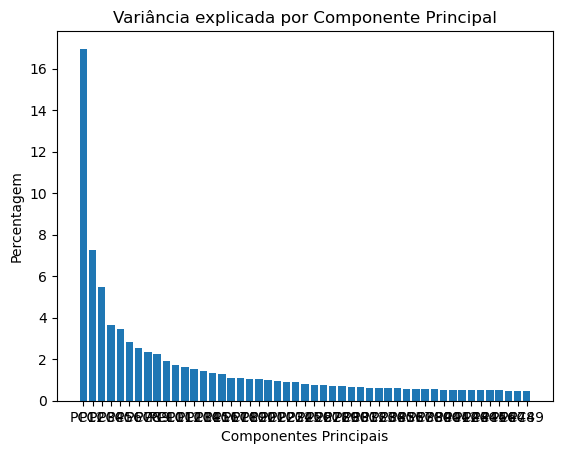

In [49]:
n=n_components
pca_cyp = PCA(n_components=n)
pca_cyp.fit(data_scaled)
X_r = pca_cyp.transform(data_scaled) 

print('Var. explicada: %s'% str(pca_cyp.explained_variance_ratio_))
print('Soma:', sum(pca_cyp.explained_variance_ratio_) * 100, "%")

plt.bar(range(n), pca_cyp.explained_variance_ratio_*100)
plt.xticks(range(n), ['PC'+str(i) for i in range(1, n+1)])
plt.title("Variância explicada por Componente Principal")
plt.ylabel("Percentagem")
plt.xlabel("Componentes Principais")
plt.show()

O PC1 explica cerca de 17% da variância, enquanto que o PC2 explica cerca de metade do anterior.

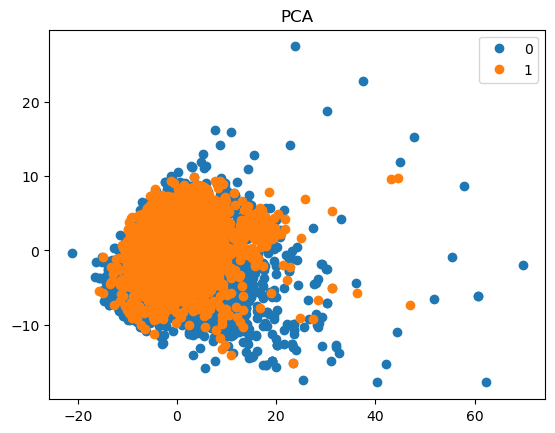

In [50]:
for i in df['Y'].unique():
    sp = df.index[df['Y']==i]-1
    plt.plot(X_r[sp,0],X_r[sp,1], 'o' , label=i)
plt.title("PCA")
plt.legend(loc='best', shadow=False)
plt.show()

Os resultados do PCA apresentam sobreposição o que pode indicar a presença de variáveis altamente correlacionadas ou redundantes, o que é confirmado em cima pela matriz de correlações. Nesse caso, as variáveis não estão a fornecer informações únicas e independentes sobre os dados, o que pode dificultar a identificação das principais fontes de variação nos dados. 

### t-SNE

In [51]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
points = tsne.fit_transform(data_scaled)

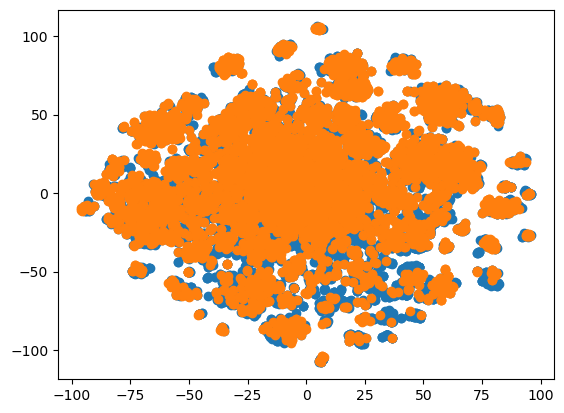

In [52]:
for s in df["Y"].unique():
    sp = df.index[df["Y"] == s]-1
    plt.plot(points[sp,0], points[sp,1], 'o', label = s)
plt.show()

O t-SNE (t-Distributed Stochastic Neighbor Embedding) é uma técnica de visualização de dados que pode ser usada para explorar a estrutura e a relação entre diferentes pontos em um conjunto de dados. 
Quando os dados estão sobrepostos significa que as informações contidas nos dados são muito complexas e características importantes dos dados podem ser de dificil identificação.

### Clustering Hierarquico

# EXPLICAR SUCINTAMENTE O QUE É CLUSTERING E O QUE PRETENDEMOS FAZER ABAIXO

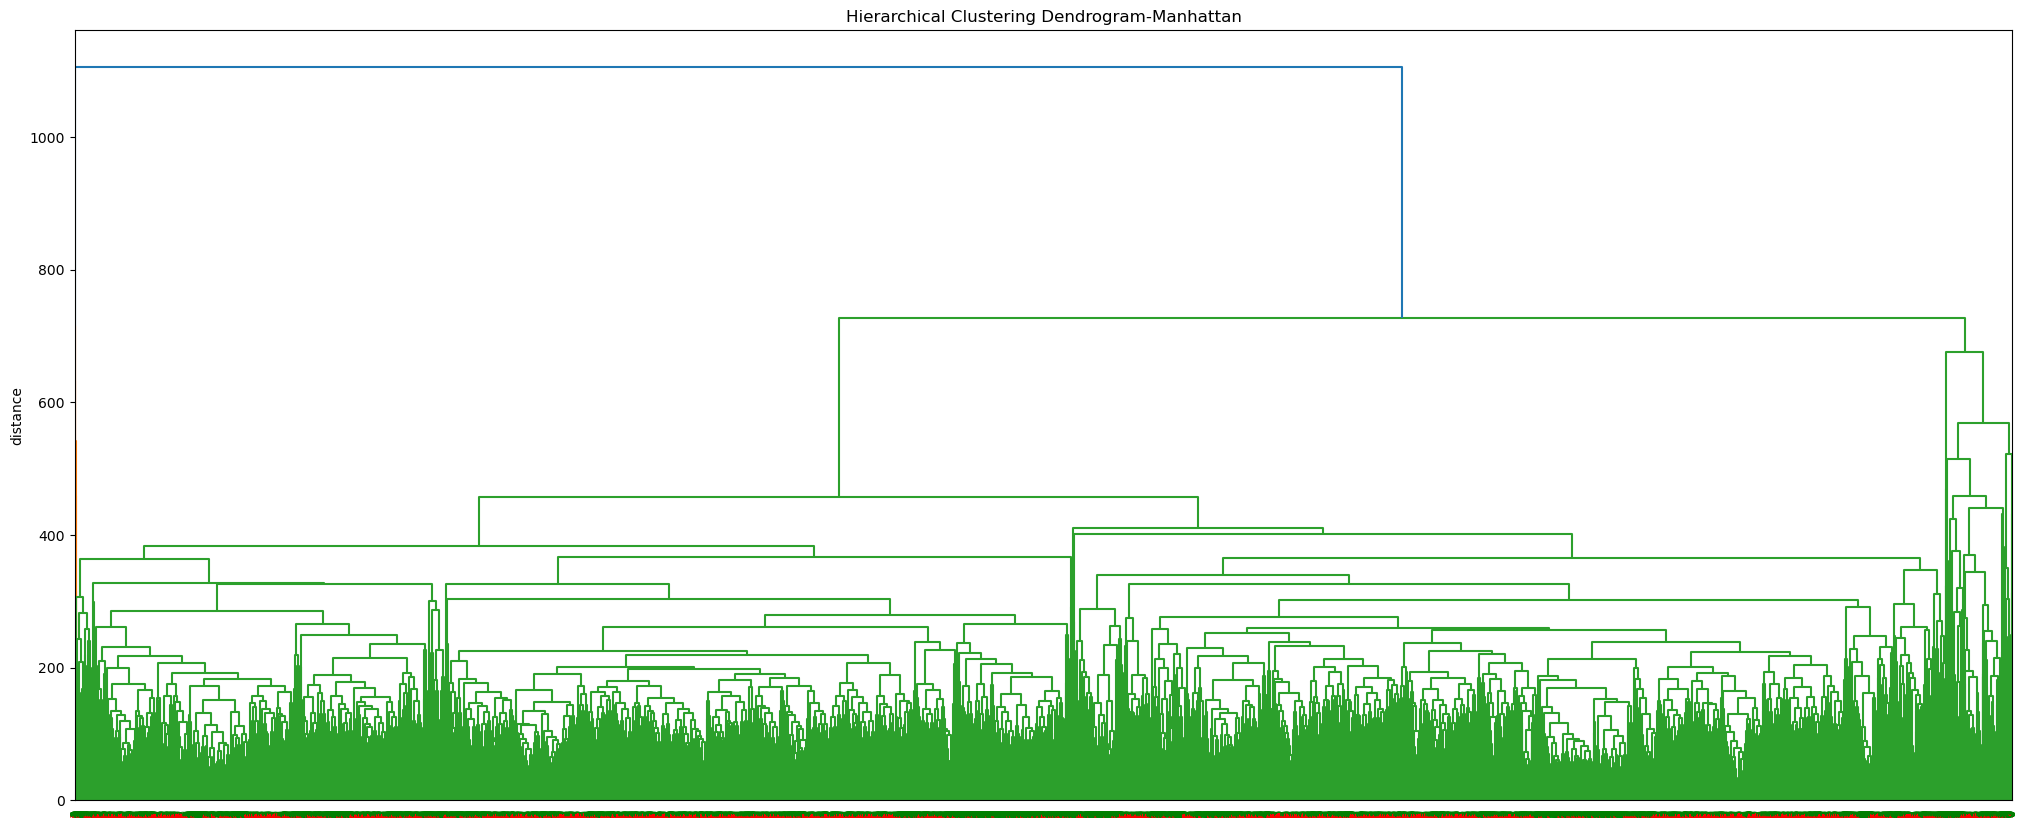

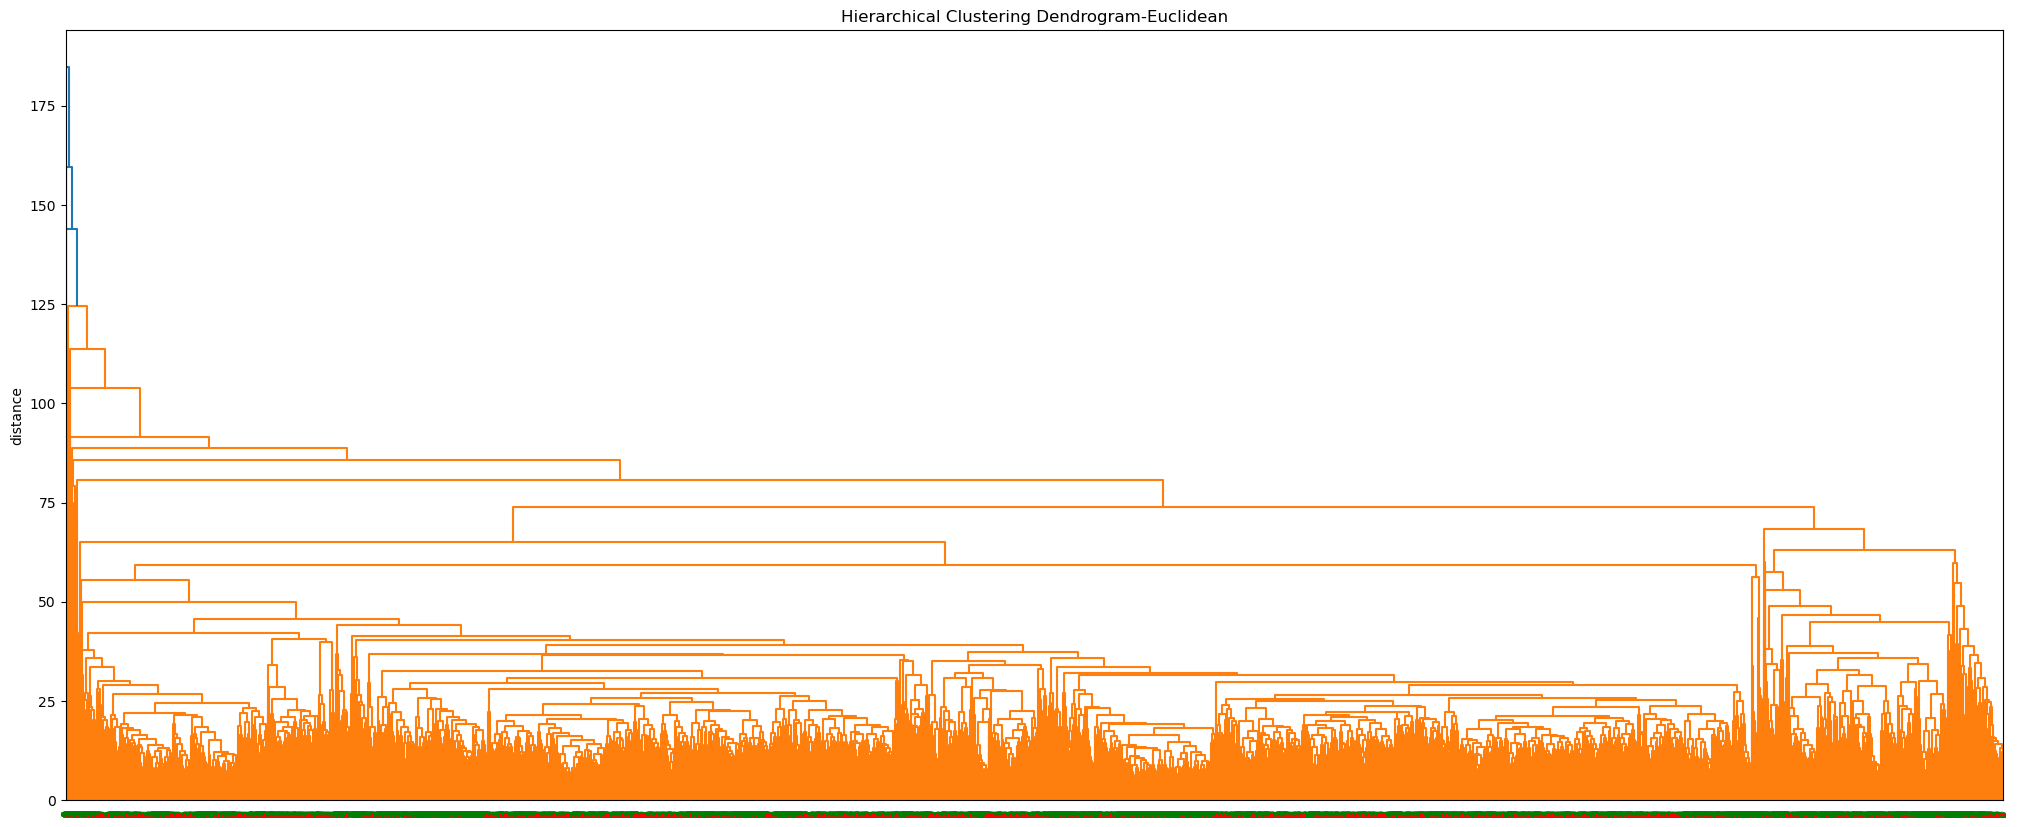

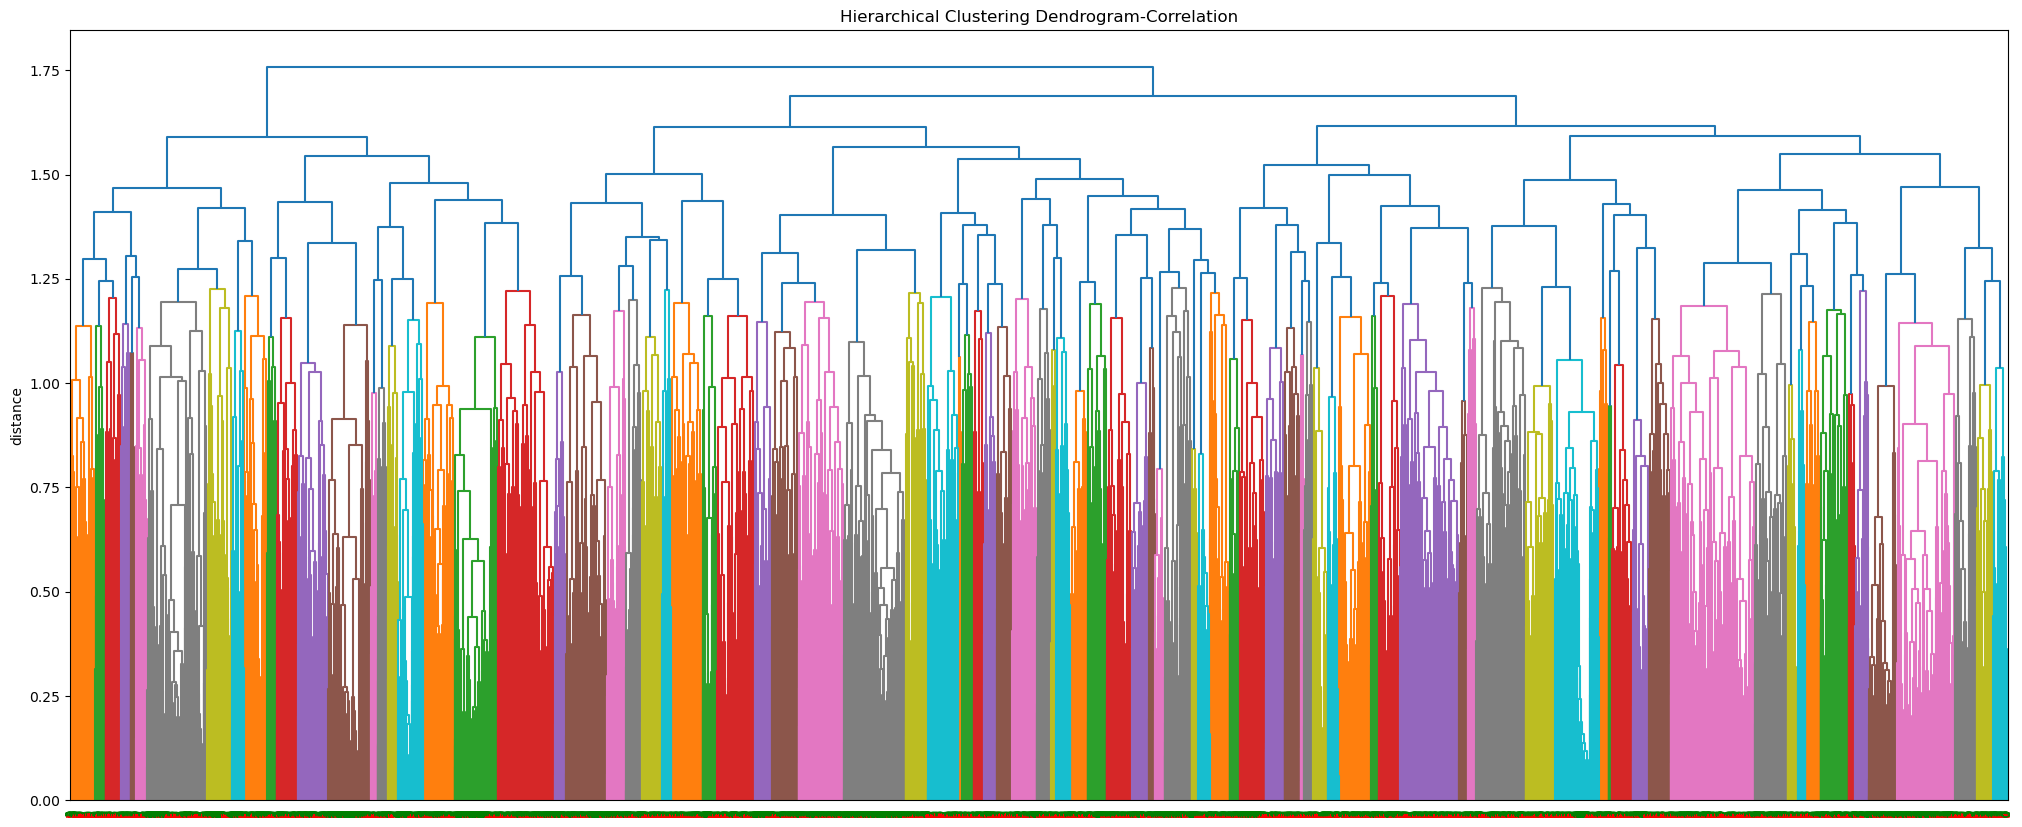

In [53]:
#Distância Manhattan
Z = linkage(data_scaled, method='complete', metric='cityblock')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(df_cyp2c19.iloc[:,2]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram-Manhattan')
plt.ylabel('distance')
# Plota o dendrograma colorindo as folhas de acordo com a classe
label_colors = {"1": 'r', "0": 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()

#Distância Euclidean
Z = linkage(data_scaled, method='complete', metric='euclidean')

#calculate full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(df_cyp2c19.iloc[:,2]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram-Euclidean')
plt.ylabel('distance')
# Plota o dendrograma colorindo as folhas de acordo com a classe
label_colors = {"1": 'r', "0": 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()

#correlation
Z = linkage(data_scaled, method='complete', metric='correlation')

#calculate full dendrogram
df['Y'] = df['Y'].astype(str)
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(df_cyp2c19.iloc[:,2]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram-Correlation')
plt.ylabel('distance')
# Plota o dendrograma colorindo as folhas de acordo com a classe
label_colors = {"1": 'r', "0": 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()

### Kmeans

In [54]:
from sklearn.cluster import KMeans

k=3
kmeans_meta = KMeans(n_clusters=k, max_iter=1000)
kmeans_meta.fit(data_scaled)
labels = kmeans_meta.labels_
centroids = kmeans_meta.cluster_centers_

pd.crosstab(labels,df["Y"], rownames=['clusters'] )

c:\Users\Fofinha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Y,0,1
clusters,,
0,3141,2340
1,665,174
2,2903,3290


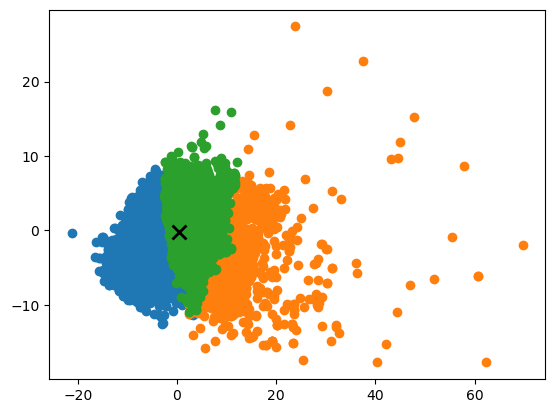

In [55]:
for i in range(k):

    ds = X_r[np.where(labels==i)]
    
    plt.plot(ds[:,0],ds[:,1],'o')

    lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
 
    plt.setp(lines,ms=10.0)    
    plt.setp(lines,mew=2.0)    
    
# plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r')

plt.show()

c:\Users\Fofinha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Fofinha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Fofinha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Fofinha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Fofinha\anaconda3\lib\site-packages\skl

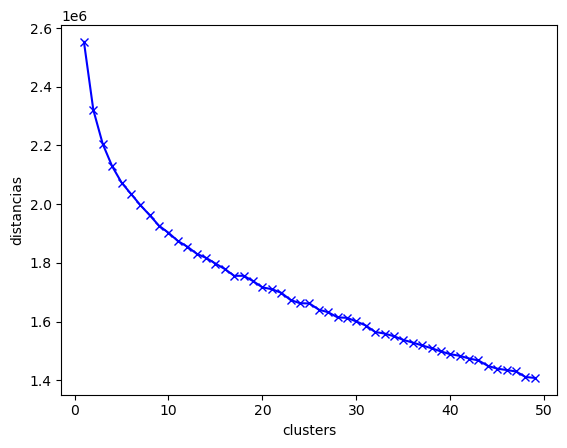

In [57]:
from sklearn.cluster import KMeans
k_values = range(1, 50)
lista = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    lista.append(kmeans.inertia_)
plt.plot(k_values, lista, 'bx-')
plt.xlabel('clusters')
plt.ylabel('distancias')
plt.show()

### Machine Learning

Para a análise de Machine Learning, vamos estudar as colunas selecionadas acima, que apresentam os 15 menores valores de p-value.

In [127]:
df_ml = df[["SMR_VSA7", "MolLogP", "VSA_EState6", "SlogP_VSA6", "NumAromaticCarbocycles", "fr_benzene", "NumAromaticRings", "FractionCSP3", "SlogP_VSA2", "PEOE_VSA6"]]

In [105]:
selected_data = df[["BertzCT", "MaxEStateIndex","MinEStateIndex","MaxAbsEStateIndex","MinAbsEStateIndex","MaxPartialCharge","MinPartialCharge", "TPSA","qed", "NumValenceElectrons", "MolWt", "Y", "FpDensityMorgan3","FpDensityMorgan2","FpDensityMorgan1"]]

selected_data

,BertzCT,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,MaxPartialCharge,MinPartialCharge,TPSA,qed,NumValenceElectrons,MolWt,Y,FpDensityMorgan3,FpDensityMorgan2,FpDensityMorgan1
0,488.27930,11.609395,0.000000,11.609395,0.000000,0.223859,-0.367762,35.58,0.884168,124.0,346.302,0,2.454546,1.909091,1.227273
1,997.90656,12.610409,-3.973681,12.610409,0.072387,0.395588,-0.413988,84.66,0.720978,114.0,355.418,1,2.681818,2.045454,1.272727
2,661.56570,6.126257,0.660427,6.126257,0.660427,0.180998,-0.258611,41.57,0.756902,88.0,255.708,1,2.388889,1.611111,0.888889
3,974.84500,5.719940,-0.219974,5.719940,0.075509,0.173203,-0.496400,72.20,0.605920,164.0,421.549,1,2.387097,1.709677,1.000000
4,818.19965,12.040634,-0.208718,12.040634,0.006714,0.243448,-0.496407,94.82,0.728361,122.0,324.344,1,2.791667,2.000000,1.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12508,483.83765,12.346902,-0.801800,12.346902,0.024123,0.232996,-0.388692,74.68,0.682518,102.0,263.293,0,2.578947,1.894737,1.210526
12509,891.82336,13.390758,-1.019880,13.390758,0.162294,0.233632,-0.389652,88.60,0.455270,152.0,397.427,0,2.586207,1.827586,1.068966
12510,638.99200,12.817440,-0.985371,12.817440,0.131139,0.233304,-0.389652,88.60,0.406549,130.0,335.356,1,2.708333,2.000000,1.250000
12511,747.82825,13.179767,-1.161112,13.179767,0.077392,0.233570,-0.390077,94.91,0.772281,138.0,357.406,0,2.346154,1.653846,1.000000


In [128]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

data_scale_ml = scaler.fit_transform(df_ml)

data_scale_ml

array([[-1.13446735,  0.35270271, -0.69093275, ...,  1.1081152 ,
         0.4332695 , -0.04341075],
       [-0.29389108, -0.2001294 , -0.46526013, ..., -1.14693903,
        -0.98421722, -0.43104096],
       [ 0.24221959,  0.43682079,  0.92774035, ..., -1.50417537,
        -0.94265417,  1.33539468],
       ...,
       [-1.57217745, -1.78865835, -1.49721939, ...,  2.04717398,
         1.50818014, -0.97679553],
       [-0.65511639, -1.09196074, -0.24992792, ...,  1.0500643 ,
         0.50061715,  0.19187823],
       [-1.10791183, -1.14861971, -1.49721939, ...,  0.60676658,
         0.08937077, -0.97679553]])

In [129]:
data_scale_ml = pd.DataFrame(data_scale_ml)
data_scale_ml.columns = ["SMR_VSA7", "MolLogP", "VSA_EState6", "SlogP_VSA6", "NumAromaticCarbocycles", "fr_benzene", "NumAromaticRings", "FractionCSP3", "SlogP_VSA2", "PEOE_VSA6"]

In [131]:
from sklearn.model_selection import train_test_split

X = data_scale_ml
y = df_cyp2c19['Y']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

train_in = X_train
train_out = y_train

test_in = X_test
test_out = y_test

(8759, 10) (3754, 10) (8759,) (3754,)


Agora vamos testar alguns modelos de Machine Learning, e inicialmente vamos guardar os resultados em variáveis para, posteriormente ser feita uma comparação.

In [132]:
modelos_ML = []
PECC_ML = []

### K-neighbours

O método k-vizinhos mais próximos (k-NN), é um algoritmo de aprendizagem máquina supervisionado usado para classificação e regressão. O método k-vizinhos mais próximos é considerado um algoritmo simples.
No k-NN, o objetivo é classificar ou prever um novo ponto de dados com base na proximidade dos seus vizinhos mais próximos no espaço de características. O "k" em k-NN refere-se ao número de vizinhos mais próximos que são considerados para tomar uma decisão.

In [133]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

knn_class = KNeighborsClassifier()

knn_class.fit(X_train, y_train)

preds = knn_class.predict(X_test)

print("Matriz de confusão:")
print(confusion_matrix(y_test, preds, labels=[0,1]))

accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc_roc = roc_auc_score(y_test, preds)

modelos_ML.append("KNN")
PECC_ML.append(accuracy)

print()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)

Matriz de confusão:
[[1491  504]
 [ 495 1264]]

Accuracy: 0.7338838572189664
Precision: 0.7149321266968326
Recall: 0.7185901080159182
F1-score: 0.716756450240998
AUC-ROC: 0.732979264534275
Error Squared Root 0.515864461637971


In [134]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(train_in, train_out)
preds = knn.predict(test_in)
print("Valores previstos: ", preds)
print("Valores reais: " , test_out)
print("Perc. acertos: ", (preds == test_out).sum()/len(preds) )

Valores previstos:  [0 1 1 ... 0 0 0]
Valores reais:  12453    0
10924    1
9158     1
7808     0
4864     0
        ..
3955     0
8897     0
6400     0
9365     1
12031    0
Name: Y, Length: 3754, dtype: int64
Perc. acertos:  0.7338838572189664


Matriz de confusão: A matriz de confusão mostra os resultados das previsões do seu modelo em relação aos valores reais. Esta indica que o modelo classificou corretamente 1995 instâncias da classe 0 e 1757 instâncias da classe 1. Houve apenas 2 instâncias da classe 0 erradamente classificadas como classe 1.

Acurácia: A acurácia é uma medida que indica a proporção de instâncias corretamente classificadas em relação ao total de instâncias. Neste caso, acurácia é de aproximadamente 0.9995, o que significa que o modelo obteve uma taxa de acerto muito alta.

Precisão: A precisão mede a proporção de instâncias corretamente classificadas como positivas (classe 1) em relação ao total de instâncias classificadas como positivas. Verificamos que a precisão é de 1.0, o que significa que todas as instâncias classificadas como classe 1 foram realmente da classe 1.

Recall: O recall, também conhecido como taxa de verdadeiros positivos, mede a proporção de instâncias positivas corretamente identificadas em relação ao total de instâncias positivas reais. O nosso resultado mostra que o recall é de aproximadamente 0.9989, o que indica que o modelo identificou corretamente a grande maioria das instâncias da classe 1.

F1-score: O F1-score é uma medida que combina a precisão e o recall em uma única métrica, levando em consideração tanto os verdadeiros positivos quanto os falsos negativos. O F1-score é de aproximadamente 0.9994, indicando um bom equilíbrio entre precisão e recall.

AUC-ROC: A área sob a curva ROC (AUC-ROC) é uma medida que avalia o desempenho do modelo em relação a taxa de verdadeiros positivos e a taxa de falsos positivos em diferentes limiares de classificação. Quanto mais próxima de 1 for a AUC-ROC, melhor é o desempenho do modelo em distinguir entre as classes. A AUC-ROC é de aproximadamente 0.9994, o que indica um desempenho muito bom.

Raiz do erro quadrático: Esta métrica mede a diferença média entre os valores previstos e os valores reais, levando em consideração o erro quadrático. No seu caso, a raiz do erro quadrático é de aproximadamente 0.0231, indicando um erro médio relativamente baixo.

Com base nos resultados fornecidos, o modelo k-NN mostra ter um desempenho excelente, com uma taxa de acerto muito alta, alta precisão e recall, além de um bom equilíbrio entre eles (F1-score). A AUC-ROC também sugere que o modelo é capaz de distinguir efetivamente entre as classes.


### Naive Bayes

O modelo Naive Bayes é um algoritmo de aprendizagem de máquina supervisionado usado para classificação. Ele é baseado no teorema de Bayes e assume independência condicional entre as características do conjunto de dados.

A ideia por trás do modelo Naive Bayes é calcular a probabilidade de uma instância pertencer a uma determinada classe com base na probabilidade das características observadas.

In [135]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

naive_bayes = GaussianNB()

naive_bayes.fit(X_train, y_train)

preds = naive_bayes.predict(X_test)

print("Matriz de confusão:")
print(confusion_matrix(y_test, preds))

accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

modelos_ML.append("Naive-Bayes")
PECC_ML.append(accuracy)

auc_roc = roc_auc_score(y_test, preds)

print()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)

Matriz de confusão:
[[1240  755]
 [ 468 1291]]

Accuracy: 0.6742141715503462
Precision: 0.6309872922776149
Recall: 0.7339397384877772
F1-score: 0.678580814717477
AUC-ROC: 0.6777468115997782
Raiz quadrada do erro: 0.5707765135757197


### Random Forest

In [169]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print("Matriz de confusão:")
print(confusion_matrix(y_test, preds, labels=[0,1]))
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc_roc = roc_auc_score(y_test, preds)

PECC_ML.append(accuracy)
modelos_ML.append("Random Forest")


print()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)


Matriz de confusão:
[[1522  473]
 [ 449 1310]]

Accuracy: 0.7543953116675546
Precision: 0.7347167694896243
Recall: 0.7447413303013075
F1-score: 0.7396950875211746
AUC-ROC: 0.7538242992358668


### Decision Tree

In [138]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_class = DecisionTreeClassifier()

decision_tree_class.fit(X_train, y_train)

preds = decision_tree_class.predict(X_test)

print("Matriz de confusão:")
print(confusion_matrix(y_test, preds))

accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

modelos_ML.append("Decision Tree")
PECC_ML.append(accuracy)

auc_roc = roc_auc_score(y_test, preds)

print()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)

Matriz de confusão:
[[1419  576]
 [ 621 1138]]

Accuracy: 0.6811401172083111
Precision: 0.6639439906651109
Recall: 0.6469584991472428
F1-score: 0.6553412035704003
AUC-ROC: 0.6791183473179823
Raiz quadrada do erro: 0.5646767949824828


In [155]:
from sklearn.neural_network import MLPClassifier

mlp_class = MLPClassifier()

mlp_class.fit(X_train, y_train)

preds = mlp_class.predict(X_test)

print("Matriz de confusão:")
print(confusion_matrix(y_test, preds, labels=[0,1]))
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc_roc = roc_auc_score(y_test, preds)

modelos_ML.append("Redes Neuronais")
PECC_ML.append(accuracy)


print()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)


Matriz de confusão:
[[1497  498]
 [ 458 1301]]

Accuracy: 0.745338305807139
Precision: 0.7231795441912173
Recall: 0.7396247868106879
F1-score: 0.7313097245643619
AUC-ROC: 0.7450003633301558
Raiz quadrada do erro: 0.504640163079457


c:\Users\Fofinha\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Modelos lineares

In [142]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression(C=1e5, solver = "liblinear", multi_class = "auto")
logistic = logistic.fit(X_train, y_train)
print(logistic)

print("Valores previstos: " , logistic.predict(X_test))
print("Valores reais: " , y_test)

LogisticRegression(C=100000.0, solver='liblinear')
Valores previstos:  [0 1 1 ... 0 0 0]
Valores reais:  12453    0
10924    1
9158     1
7808     0
4864     0
        ..
3955     0
8897     0
6400     0
9365     1
12031    0
Name: Y, Length: 3754, dtype: int64


In [143]:
regr_model = linear_model.LinearRegression()
regr_model = regr_model.fit(X_train, y_train)
print(regr_model)
print("Valores previstos: " , regr_model.predict(X_test))
print("Valores reais: " , y_test)

LinearRegression()
Valores previstos:  [0.11261226 0.67395614 0.51118727 ... 0.45268819 0.35965915 0.21831992]
Valores reais:  12453    0
10924    1
9158     1
7808     0
4864     0
        ..
3955     0
8897     0
6400     0
9365     1
12031    0
Name: Y, Length: 3754, dtype: int64


#### SVM

In [152]:
svm_model = svm.SVC(gamma=0.001, C=100.)

svm_model = svm_model.fit(X_train, y_train)
preds_svm = svm_model.predict(X_test)
pec = (preds_svm == y_test).sum()/len(preds_svm)
print("Perc. acertos: ", pec )
print("Matriz de confusão: ")
print(confusion_matrix(y_test, preds_svm) )
print("F1: ", f1_score(y_test, preds_svm, pos_label = 1))

PECC_ML.append(pec)
modelos_ML.append("SVM")

Perc. acertos:  0.7083111347895578
Matriz de confusão: 
[[1343  652]
 [ 443 1316]]
F1:  0.706198014488865


#### Redes neuronais

## Comparação dos modelos estudados

In [156]:
from prettytable import PrettyTable
tabela = PrettyTable()
tabela.field_names = ['Modelo', "Precisão"]
for model, prec in zip(modelos_ML, PECC_ML):
    tabela.add_row([model, prec])
print(tabela)

+-----------------+--------------------+
|      Modelo     |      Precisão      |
+-----------------+--------------------+
|       KNN       | 0.7338838572189664 |
|   Naive-Bayes   | 0.6742141715503462 |
|  Random Forest  | 0.7559936068193926 |
|  Decision Tree  | 0.6811401172083111 |
|       SVM       | 0.7083111347895578 |
| Redes Neuronais | 0.745338305807139  |
+-----------------+--------------------+


# DESCREVER O MELHOR MODELO E FALAR SEI LÁ

### Deep Learning

Área da Aprendizagem Máquina caracterizada pela maior complexidade dos
modelos e pela capacidade de aprender representações dos dados de entrada.
Modelos de deep learning consistem em camadas sucessivas de
representações, sendo estas em número tipicamente elevado (deep)

In [162]:
conda install tensorflow

     -------------------------------------- 272.8/272.8 MB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 4.0 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 3.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     -------------------------------------- 422.5/422.5 kB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 4.1/4.1 MB 3.7 MB/s eta 0:00:00
     ---------------------------------

In [165]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()

# Add layers to the model
model.add(Dense(units=64, activation='relu', input_dim=10))  # Example input layer
model.add(Dense(units=32, activation='relu'))  # Example hidden layer
model.add(Dense(units=1, activation='sigmoid'))  # Example output layer

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32)
loss, accuracy = model.evaluate(X_test, y_test)
print("\n" "Loss:", loss, "\n"
      "Accuracy:", accuracy)

Epoch 1/10
274/274 [==============================] - 7s 9ms/step - loss: 0.5737 - accuracy: 0.7028
Epoch 2/10
274/274 [==============================] - 2s 8ms/step - loss: 0.5424 - accuracy: 0.7254
Epoch 3/10
274/274 [==============================] - 2s 8ms/step - loss: 0.5303 - accuracy: 0.7391
Epoch 4/10
274/274 [==============================] - 2s 8ms/step - loss: 0.5244 - accuracy: 0.7432
Epoch 5/10
274/274 [==============================] - 2s 8ms/step - loss: 0.5211 - accuracy: 0.7460
Epoch 6/10
274/274 [==============================] - 2s 9ms/step - loss: 0.5157 - accuracy: 0.7486
Epoch 7/10
274/274 [==============================] - 3s 10ms/step - loss: 0.5132 - accuracy: 0.7508
Epoch 8/10
274/274 [==============================] - 2s 9ms/step - loss: 0.5087 - accuracy: 0.7489
Epoch 9/10
274/274 [==============================] - 2s 8ms/step - loss: 0.5063 - accuracy: 0.7545
Epoch 10/10
274/274 [==============================] - 2s 8ms/step - loss: 0.5039 - accuracy: 0.758

### Seleção e Importância de variáveis

                 Variável  Importancia
0                SMR_VSA7     0.124723
1                 MolLogP     0.222781
2             VSA_EState6     0.127835
3              SlogP_VSA6     0.112903
4  NumAromaticCarbocycles     0.014393
5              fr_benzene     0.014669
6        NumAromaticRings     0.037133
7            FractionCSP3     0.126961
8              SlogP_VSA2     0.133460
9               PEOE_VSA6     0.085143


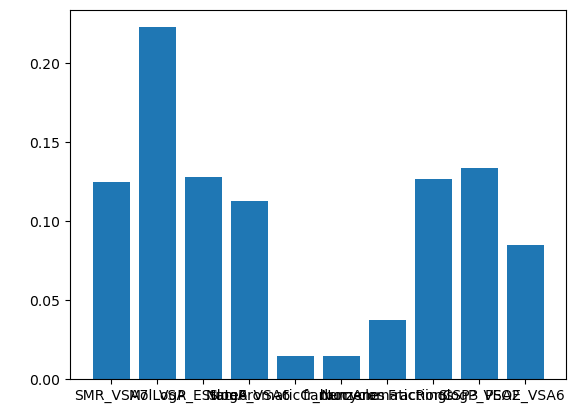

In [170]:
import matplotlib.pyplot as plt
importancias = rf.feature_importances_
df_impor = pd.DataFrame({'Variável': X.columns, 'Importancia': importancias})
print(df_impor)

#df_impor = df.Importancia.sort_values(ascending = False)
plt.bar(df_impor['Variável'], df_impor['Importancia'])
plt.ylabel(" ")

plt.show()

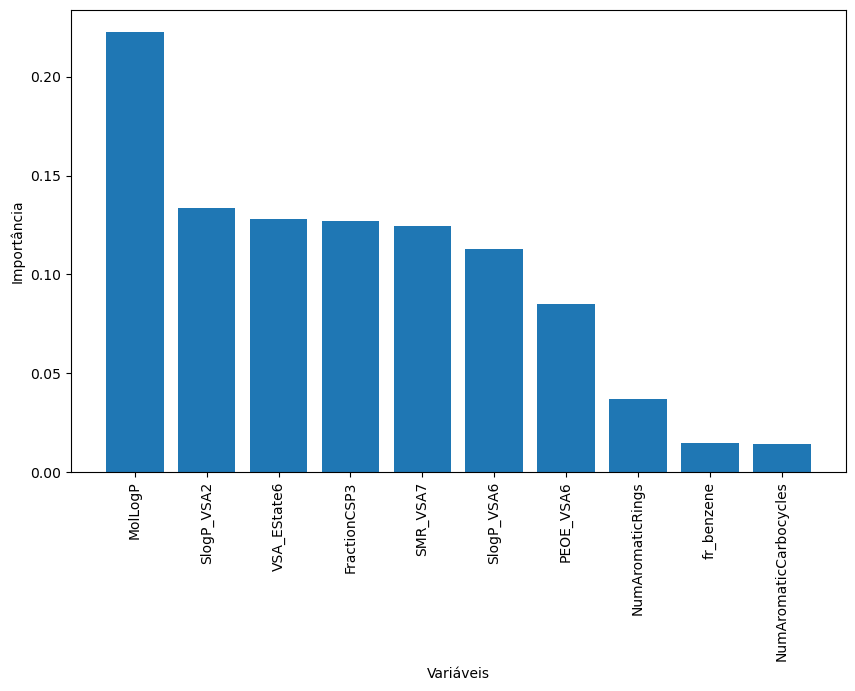

In [172]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]
feature_names = df_ml.columns
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.show()